In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
#import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
from sklearn.cluster import MeanShift, estimate_bandwidth
import multiprocessing 
import time
import cesium.featurize
from plotnine import ggplot

## 1. Project Context & Background

This project based on a Kaggle competition (link: https://www.kaggle.com/c/PLAsTiCC-2018). The very basic idea is to study the light curves (will be defined shortly) of various astronomical objects and develop an algorithm to classify such objects. There is also a great documentation on explaining the astronomy sides of the project by the host of this competition ( https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit) and I have learned most of the astronomy material specifically related to this project from this documentation.

The data comes from a telescope called LSST. If we scan sky using the telescope repeatedly, we can identify astrophysical sources in the night sky that change in brightness over time, and we can create a plot of the the brightness vs time. Such time series are called 'light curves'.

The motivation of the project is that, using this method of studying the light curves, or equivalently photometry, we are able to gather a large amount of data and detect fainter objects compared to the traditional method like spectroscopy. Note that using spectroscopy, we are able to split the light in a much more accurate resolution and retrieve the exact compositions of light sources. The only problem with spectroscopy is the telescope time and a condition on the quality of the sources. And the idea of this project is to identify the objects without the help of spectroscopy.

The goal of my report is to provide an overview of both the project and the progress around the training data so far. Since by the time of the submission there is still some time before the competition closes, I will include some other stuff I have not yet implemented but might be important.

## 2. Data Exploration

#### 2a. Time series

The training data comes with 2 files. The first file is the time series data:

In [5]:
train = pd.read_csv('training_set.csv')
print(train.head())

   object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1


object_id: The unique object id to label a source.

mjd: The time of the measurement. It is the number of decimal days from midnight on November 17, 1858.

Passband: The passband that the observation at time mjd was taken. (A filter that only allows a certain part of light to go through. See below image provided by LSST: 

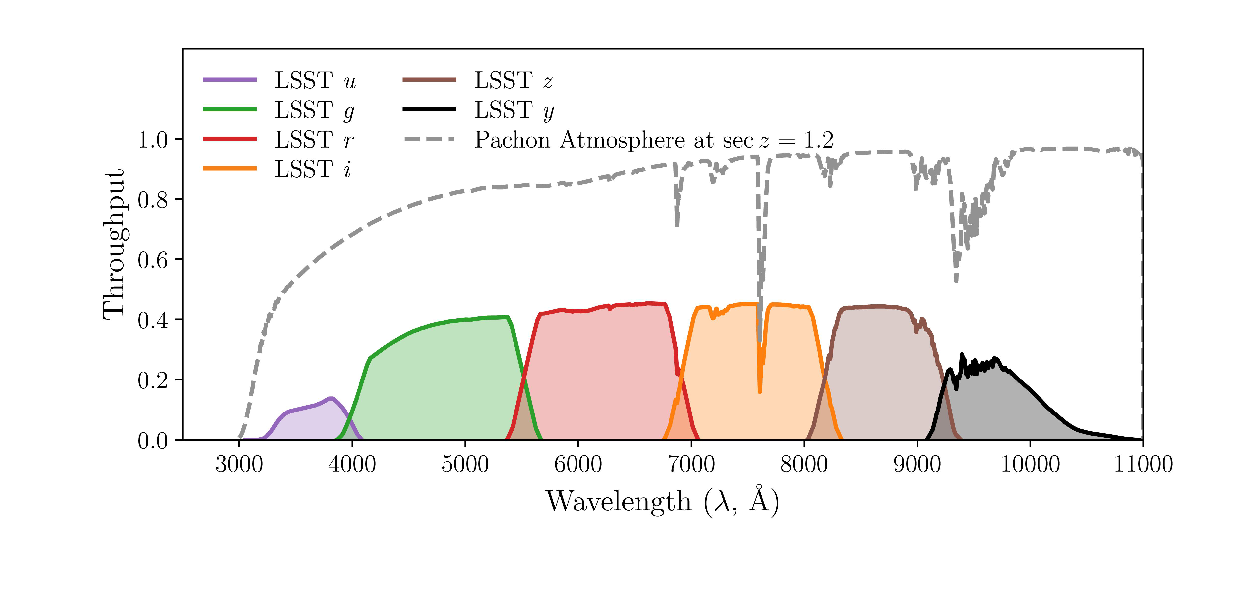

flux: Contains the actual photometry - the measurements of brightness of this source as a function of time. This value is the normalized count of photons. This is basically calculated using a reference template and taking the difference between the measurement and the template. 

flux_err: The 68% confidence interval of the measurement.

detected: Boolean. A measurement with S/N > 3 is labeled as detected. The exact details on how this value is calculated is not thoroughly explained in the documentation, but for certain events or classes like supernovae this value can help us identify the measurements that are significant instad of pure noises.

#### 2b. Mega data


The second file we have is the mega data file. This includes information on each objects that does not change over time.

In [13]:
mega_train = pd.read_csv('training_set_metadata.csv')

In [14]:
mega_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [18]:
print('The number of objects: ' ,len(mega_train))
print('The number of classes: ', len(np.unique(mega_train.target)))

The number of objects:  7848
The number of classes:  14


Some important columns worth mentioning:

ddf: Boolean. Stands for deep drilling field. A ddf with 1 means the object gets more telescope time = more meansurements
    
hostgal_photoz: The redshift estimated from photometry. Note that the hostgal_specz is an accurate measurement of redshift using spectroscopy. However, the spectroscopy version is mostly missing in the testing data, so I decided to not use hostgal_specz.

Target: The label of classes. There are 14 classes in total.

#### 2c. Exploratory analysis

The redshift is an important feature. Having redshift itself is a strong bias yet valuable information in classification. Objects with higher redshift are moving away from us, and it also means they are far away from us. Only seeing bright objects with very high redshift is somewhat a bias yet informative thing to think about. Also it might means the same objects with varying redshift will exhibit different behaviors in different passbands since their light distribution is shifted 'redder'.

I also want to quickly mention that the classes we are trying to predict is either 'extragalatic' or 'galatic', meaning they will have 0 redshift if they are within Milky-Way. Hence just by including the redshift in the classfier, we are able to do a lot better than random guessing. 

Although we are not using hosgal_specz, I still plotted a graph of hostal_spez vs. hostal_photoz. It seems like photometry estimation seems to over estimate redshift a lot. (hostal_spez can be crudely considered as what true redshift should be)

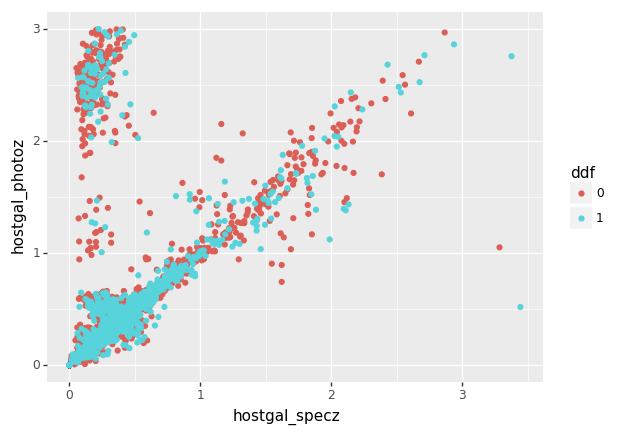

<ggplot: (-9223372036578024928)>

In [20]:
ggplot(mega_train) + aes('hostgal_specz','hostgal_photoz', color='ddf', group='ddf') + geom_point()

ddf counts vs. non-ddf counts: 

In [16]:
print(mega[mega.ddf == 1].shape[0], mega[mega.ddf == 0].shape[0])

2116 5732


The class distribution is also somewhat imbalanced. When training the classifier(s), instead of using the usual multi-log loss, I will re-weight the objects. However, I am not fully done with experimenting the cost functions, since the training data is NOT representative of test data. This is mentioned by LSST that the test data has a slightly different distribution of classes and is made of higher redshift objects. For this project specifically, I will not go into the details of optimizing model performances on test data but I thought I might as well mention it.

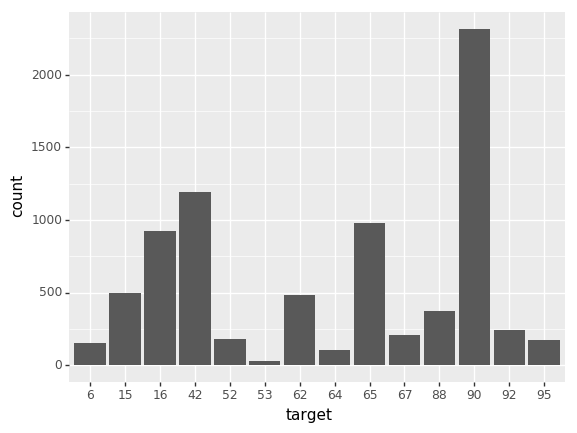

<ggplot: (-9223372036547792054)>

In [35]:
ggplot(mega_train) + aes('target') + geom_bar()

Here we can see the distribution of 'mjd', the time of measurement. Note that the distribution is not uniform, meaning we are more likely to have observations during times around 59000, 60200, and 60600. As we will see later, most the light curves are sampled pretty badly (uneven sampling), and the measurements are generally divided into 3 windows.

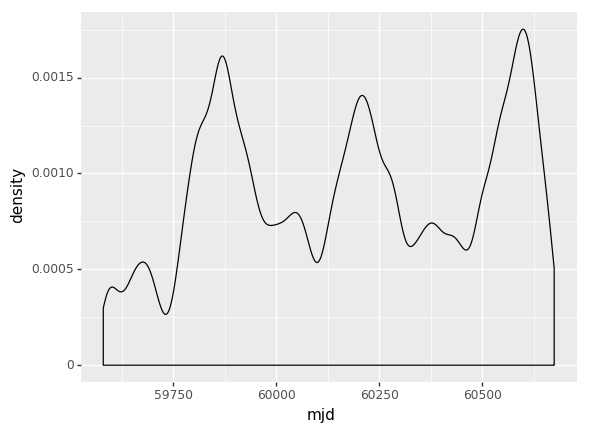

<ggplot: (-9223372036569323853)>

In [7]:
ggplot(train) + aes('mjd') + geom_density()

A follow up on the distribution of number of measurements of each objects. DDF objects tend to have more measurements. Note this is the total number of measurements of each objects across all 6 bands.

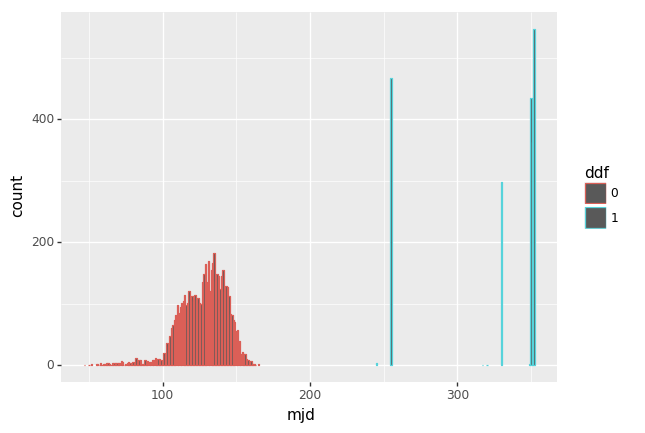

<ggplot: (-9223372036548585542)>


In [19]:
gg = ggplot(train.groupby('object_id').count()['mjd'].reset_index().merge(mega, on='object_id', how='left'))
gg += aes('mjd', group = 'ddf', color ='ddf') 
gg += geom_bar()
#gg += facet_wrap('~ target')
print(gg)

## 3. Light Curve Exploration

In this section, I want to plot some curves so we can get some ideas on what they look like and what features we can extract from those curves. This section is inspired by https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated and https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo.

If we look at the original light curves, it is fairly challenging to infer anything because of the large gaps in between observations. One technique we can use is to plot the phase curve. Here we use the Lomb-Scargle Peridogram to estimate the frequency of the objects. This method is a special case of discrete Fourier transformation that deals with uneven sampling. Using the phase plot, we are able to see the periodic behaviors the objects may have. By doing that, we also make assumptions on periodicity of the objects. Although it would be obvious if objects do not have periodicity.

Here I will plot the first 5 objects of some classes to see what those classes look like.

### Class 92

In [3]:
from plot_curves import *

Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 4.2e+02
 - Computing periods at 42432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42724 steps
Zooming-in on 5 candidate 

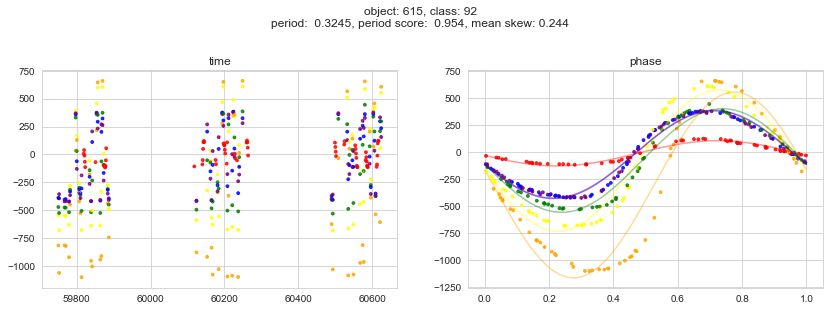

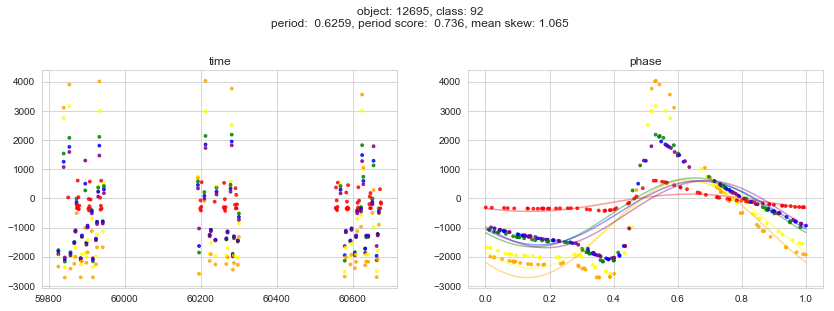

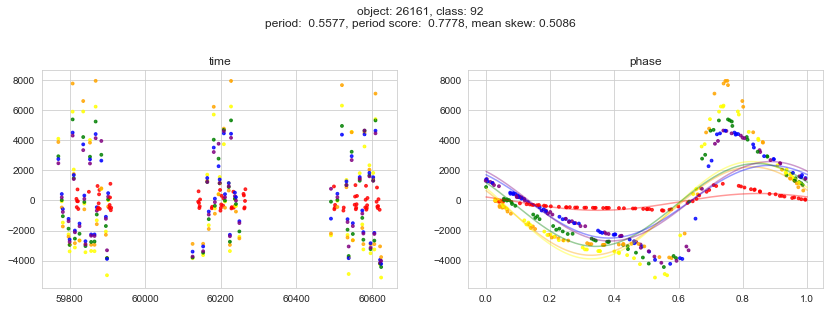

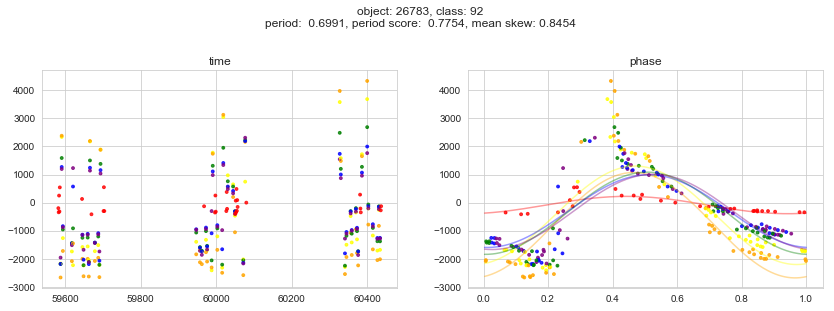

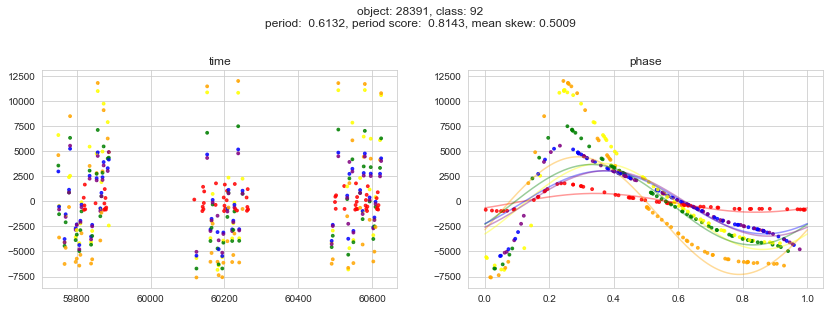

In [25]:
feats, models = get_class_feats(92)
plot_phase_curves(feats, models)

#### Obervation:
Class 92 has a very strong peridicity across all passbands. Their frequency is similar in all passbands. Looking at the variance in those frequencis in different passbands seems to be a good feature to identify this class.

### Class 90

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42724 steps
Zooming-in on 5 candidate 

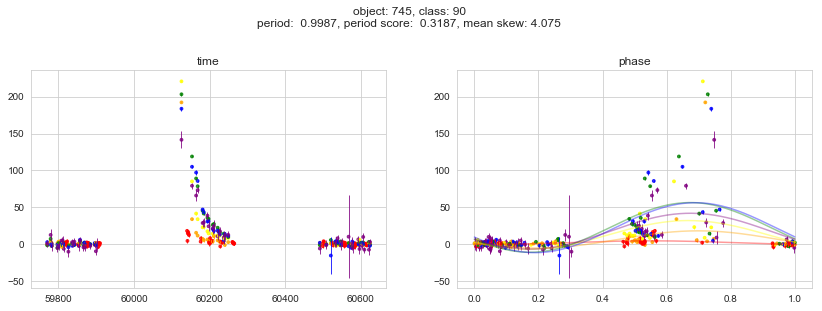

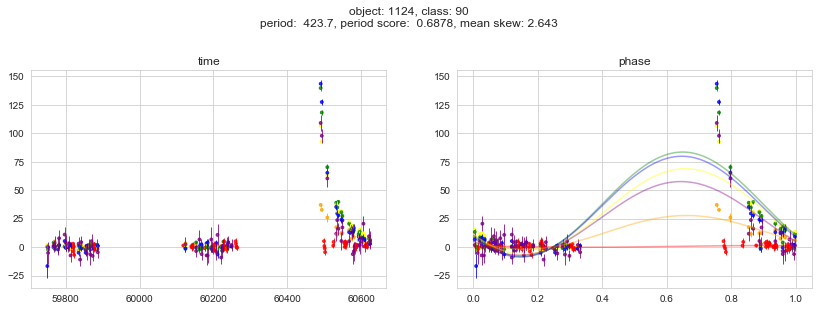

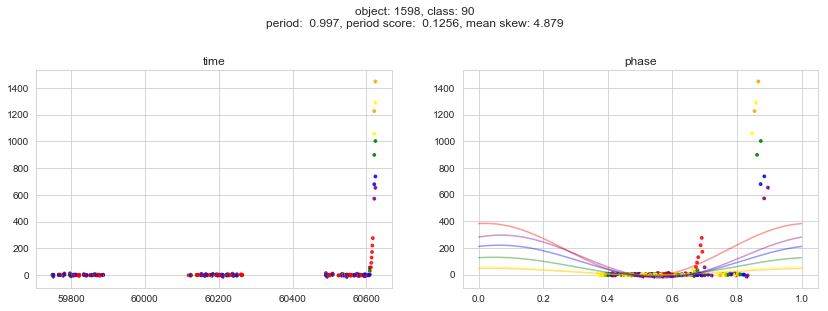

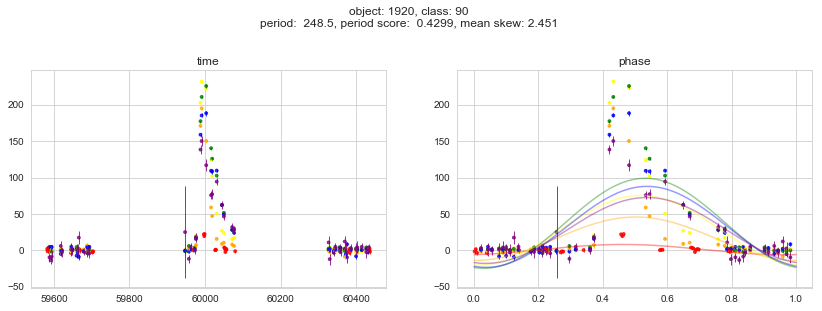

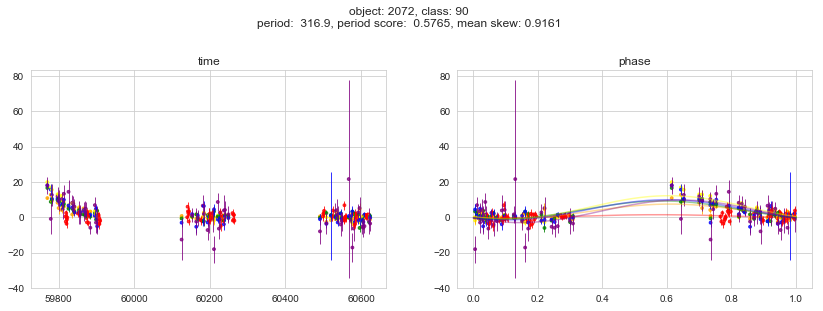

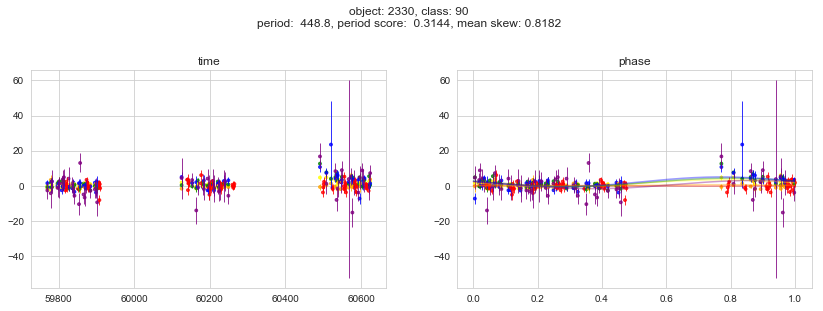

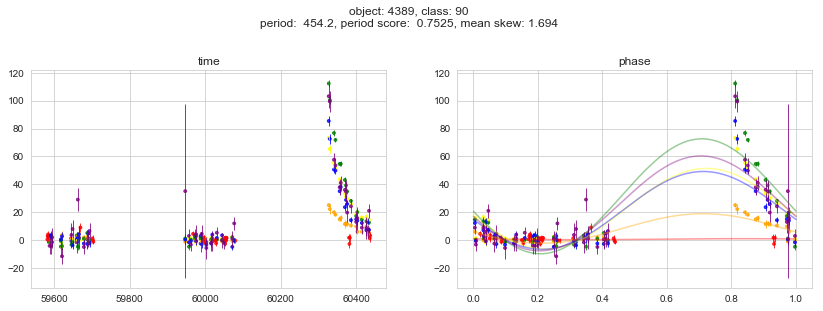

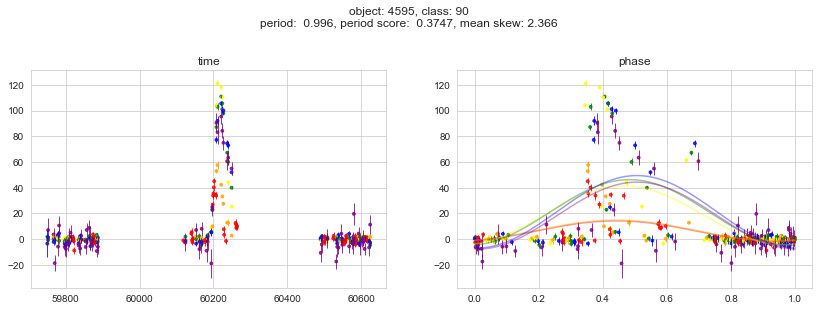

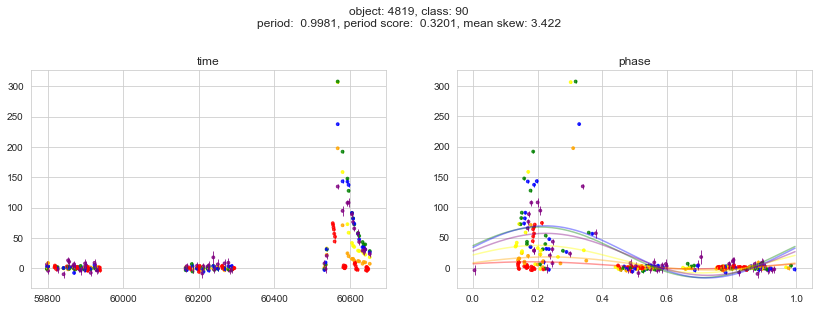

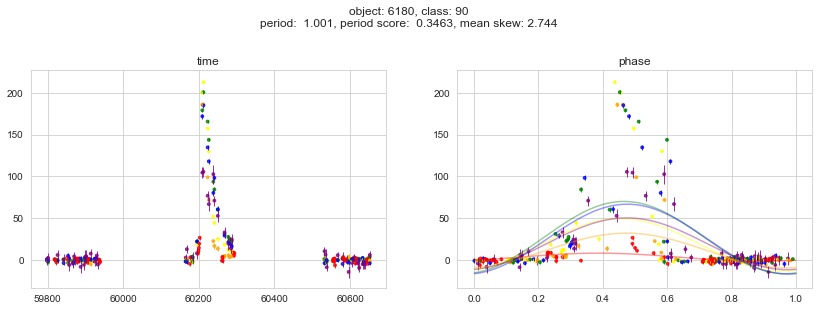

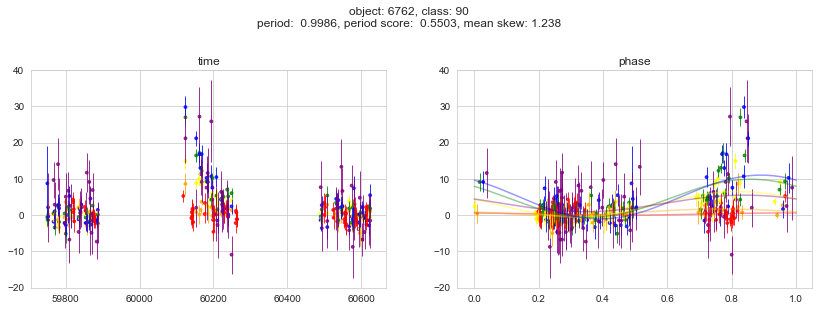

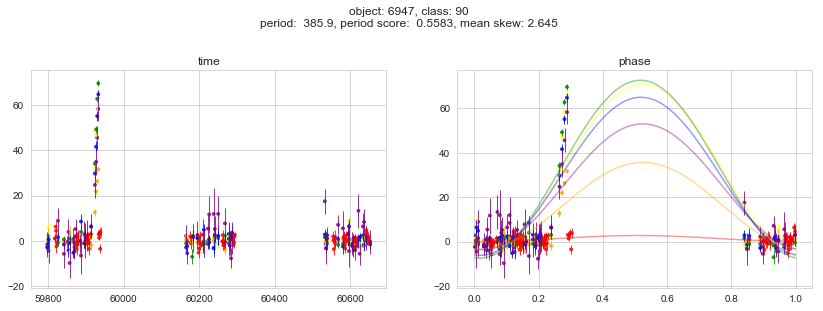

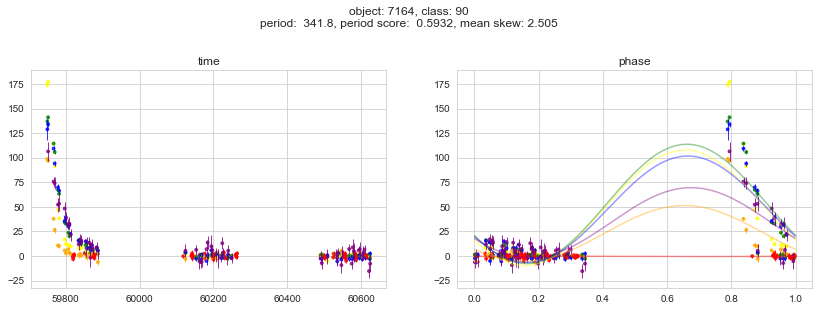

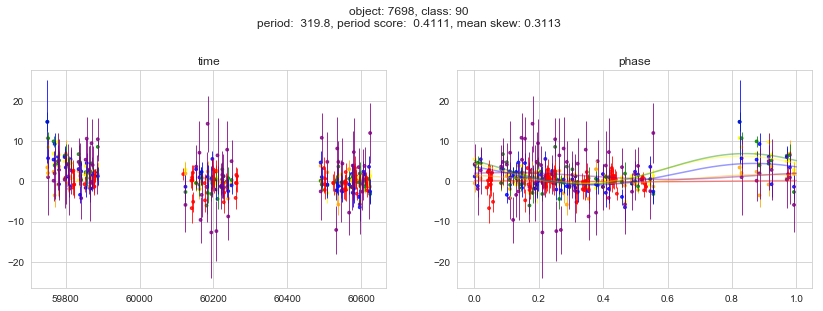

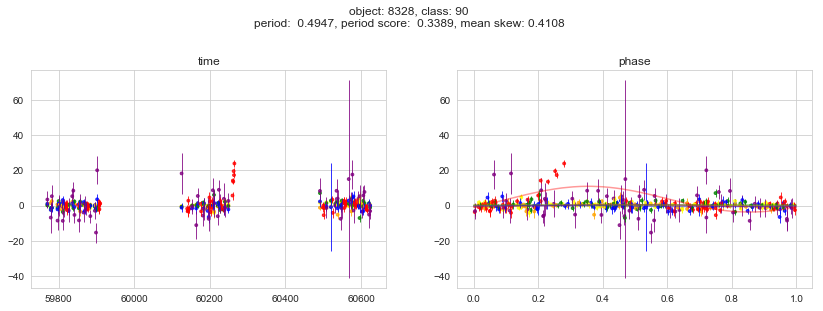

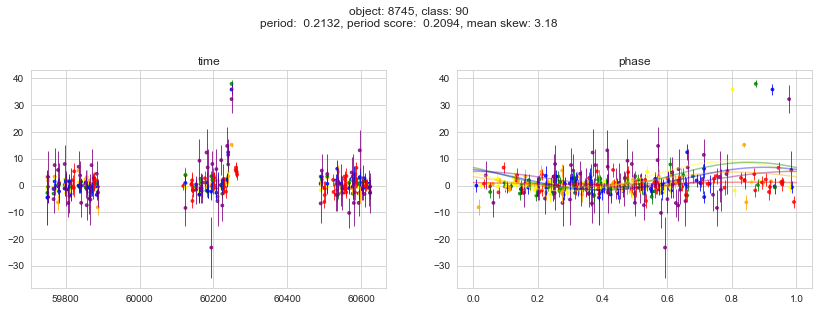

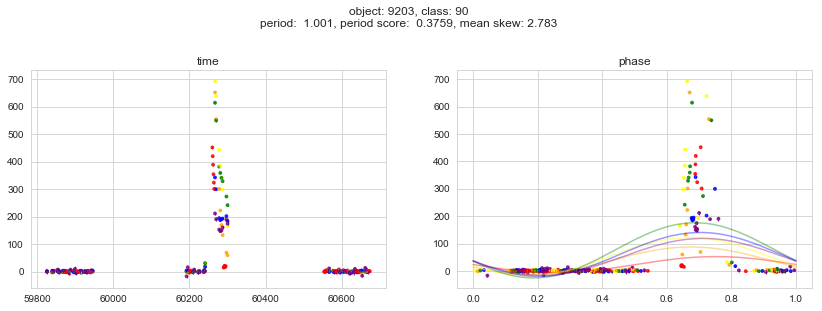

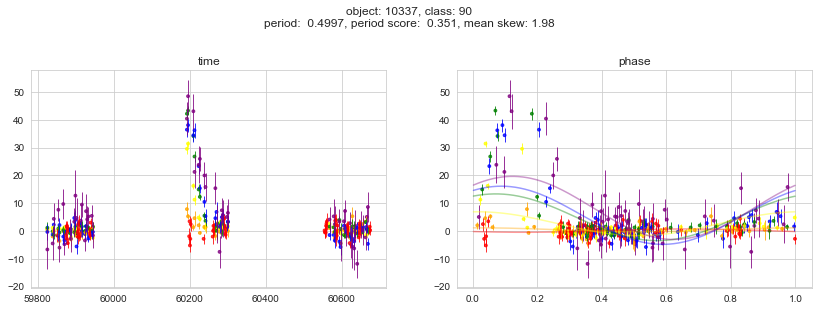

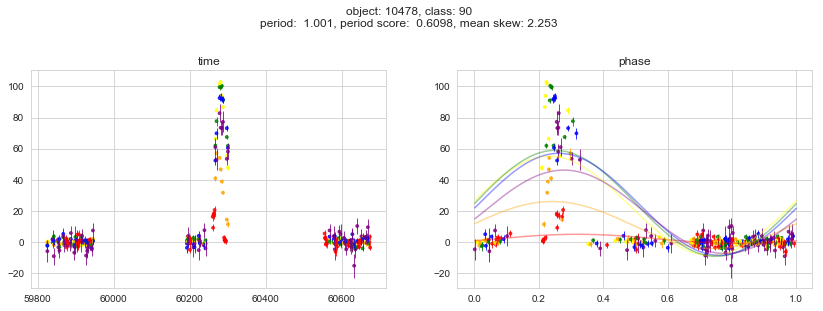

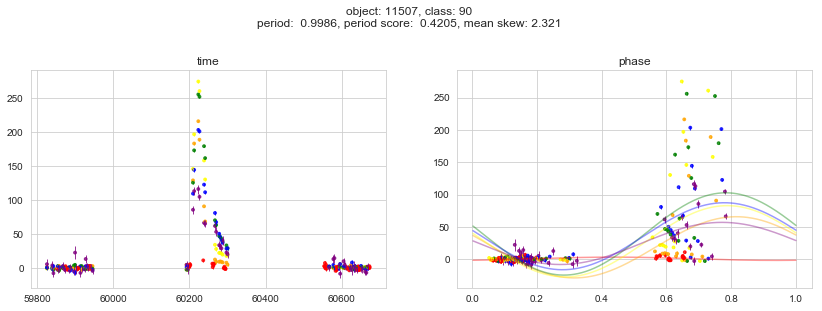

In [4]:
feats, models = get_class_feats(90)
plot_phase_curves(feats, models)

In [115]:
train[train.object_id ==2072][train.passband ==2][train.mjd<60000]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,object_id,mjd,passband,flux,flux_err,detected
3279,2072,59770.3662,2,19.925980,0.644723,1
3284,2072,59779.3999,2,16.909536,2.056421,1
3289,2072,59782.2372,2,15.633873,1.229459,1
3294,2072,59797.3336,2,13.038956,0.995182,1
3299,2072,59800.2328,2,12.899019,2.295076,1
3304,2072,59808.2223,2,12.121127,1.383560,1
3309,2072,59811.1280,2,8.819006,1.093664,1
3314,2072,59814.1206,2,8.597062,0.915267,1
3325,2072,59826.3574,2,6.870495,0.892186,1
3330,2072,59836.1402,2,7.955911,1.404179,1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


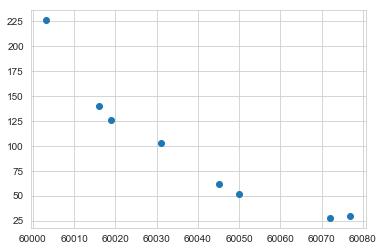

In [110]:
plot_df = train[train.object_id ==1920][train.passband ==3][train.mjd>60000][train.mjd<60200]
x = plot_df['mjd']
y = plot_df['flux']
plt.scatter(x, y)
plt.show()

In [8]:
class_90 = [745, 1124, 1598, 1920, 2072, 2330, 4389, 4595, 4819, 6180]
#class_90 = [6762, 6947, 7164, 7698, 8328, 8745,9203, 10337, 10478, 11507]
mega_train = pd.read_csv('training_set_metadata.csv')
mega_train[mega_train['object_id'].isin(class_90)]

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
10,2072,0.965665,-46.375080,325.845907,-68.579427,1,0.1516,0.1900,0.0104,39.8317,0.007,90
13,2330,359.805206,-46.768478,327.135979,-67.829903,1,0.4541,0.5736,0.2827,42.6207,0.011,90
27,4389,151.699219,3.583322,236.533224,44.205648,1,0.2333,0.2205,0.9667,40.1939,0.016,90
28,4595,349.615387,-63.636005,318.927246,-50.506542,1,0.5919,0.5995,0.0127,42.7370,0.018,90
29,4819,35.332031,-5.979157,172.286722,-59.931743,1,0.3053,0.2870,0.0076,40.8445,0.022,90
31,6180,33.222656,-4.780192,167.515653,-60.396584,1,0.3201,0.2685,0.5211,40.6793,0.018,90


[ 1.82073295  0.16552118 -0.24828177 -0.66208471 -1.07588766]


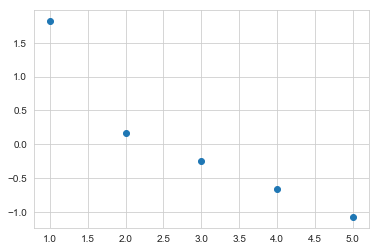

In [147]:
test_array = np.array([80,40,30,20,10])
test_array = (test_array - test_array.mean()) / test_array.std()
y = test_array
print(y)
x = np.array([1,2,3,4,5])
plt.scatter(x,y)
plt.show()

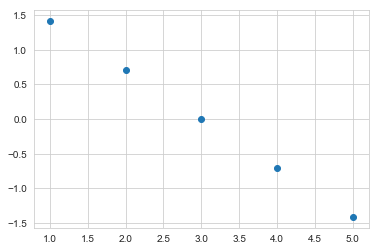

In [150]:
test_array = np.array([100,90,80,70,60])
y = (test_array - test_array.mean()) / test_array.std()
x = np.array([1,2,3,4,5])
plt.scatter(x,y)
plt.show()

#### Observation:
Class 90 is likely to be a type 1a supernova because of the its sudden burst and gradual decline in light curves. Note that its light curves have this convex shape in flux decrease after the explotion, where it drops dramatically right after the burst and then cools down - likely due to the decay of nickle and then the decay of Cobalt. (https://en.wikipedia.org/wiki/Type_Ia_supernova)

### Class 88

Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 4.2e+02
 - Computing periods at 42432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42724 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate 

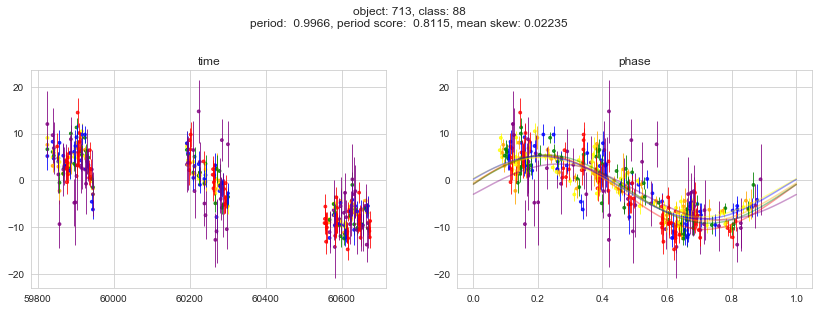

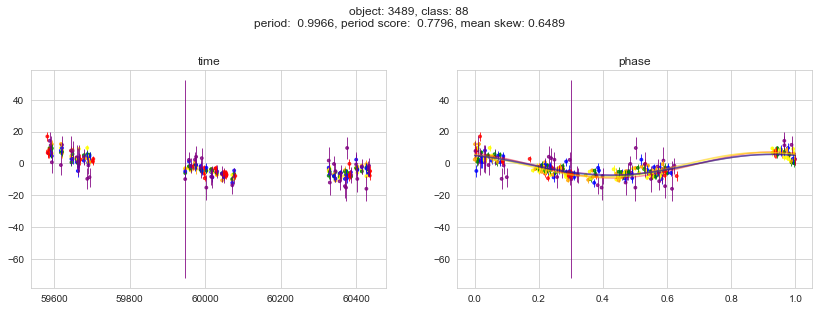

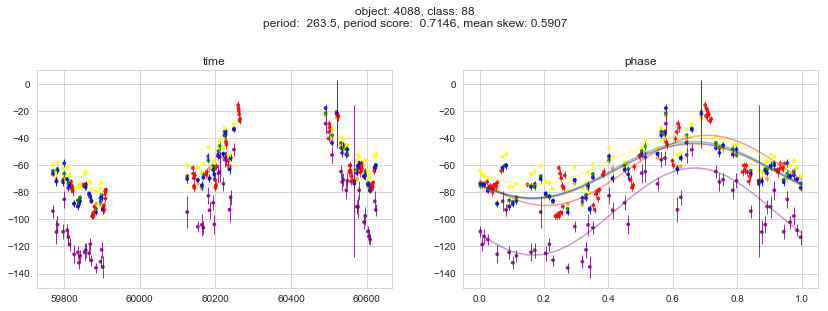

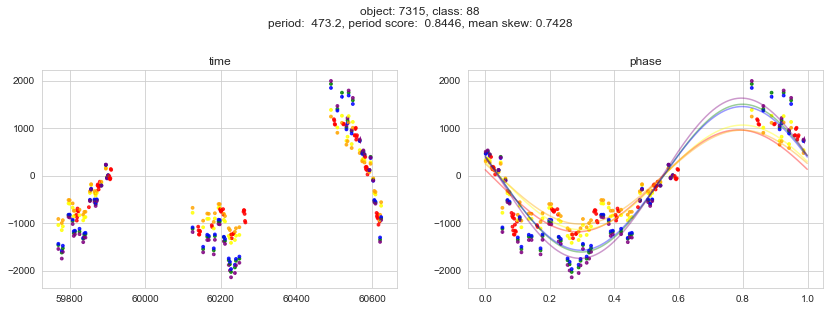

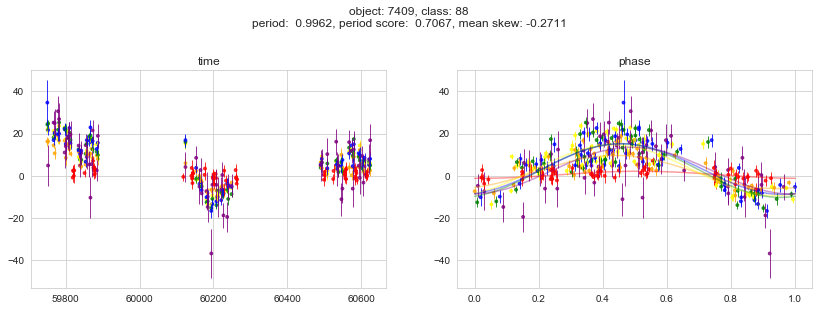

In [28]:
feats, models = get_class_feats(88)
plot_phase_curves(feats, models)

#### Observation:
Similar to class 92, this class seems to be fairly periodic, which makes its frequencies great features to identify these objects. Unlike class 92, this class is extragalactic, we should be able to separate it from class 92 from the its non zero redshift and high volatile measurement errors.

### Class 62

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 4.2e+02
 - Computing periods at 42432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate 

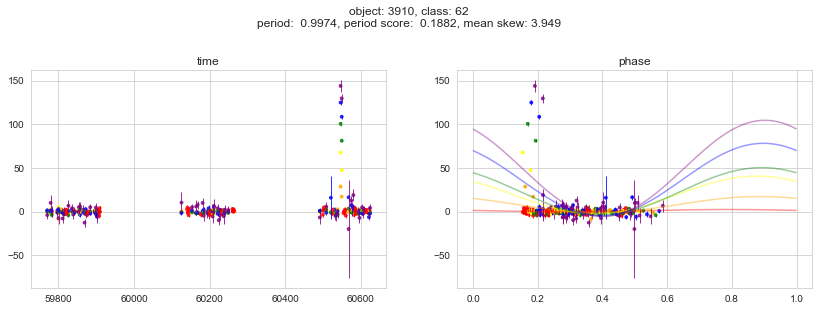

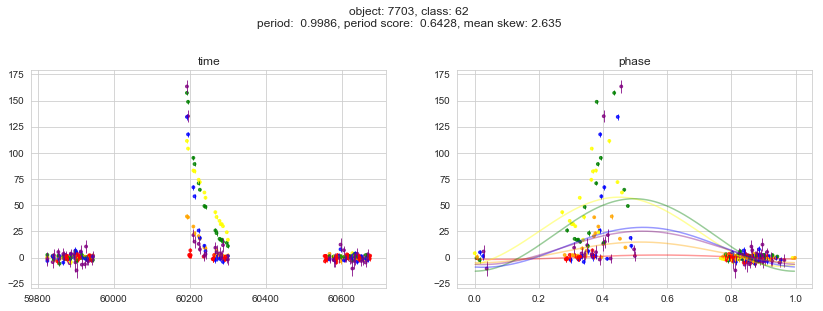

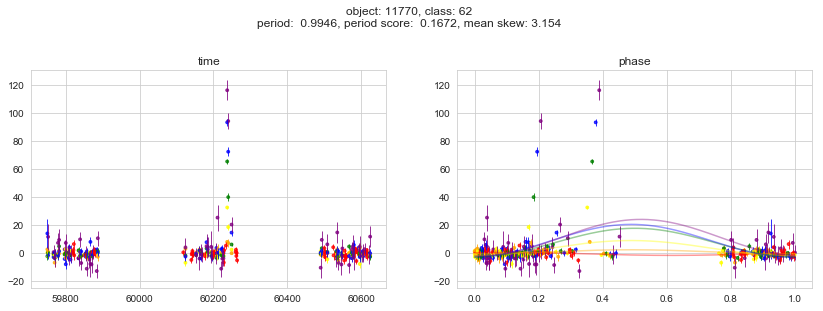

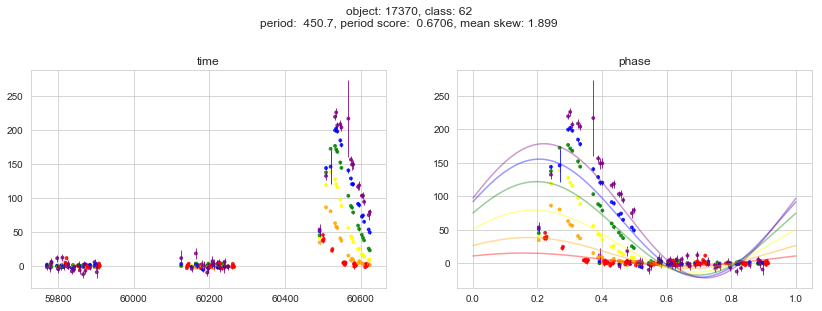

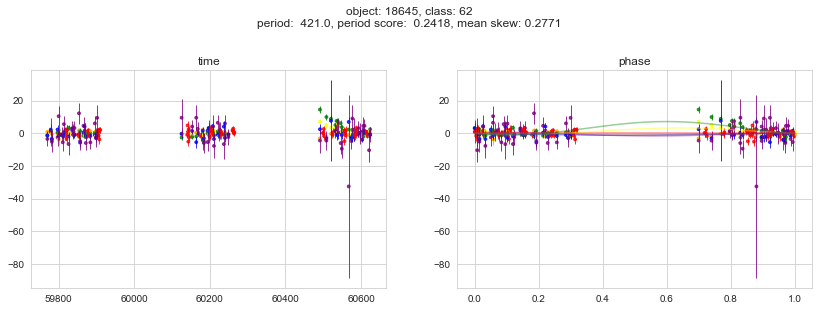

In [30]:
feats, models = get_class_feats(62)
plot_phase_curves(feats, models)

#### Observation:
Class 62 is probably some kind of supernova as well. The general strategy I have in mind is to focus on their measurements around the peaks and calculate their decay rate. 

### Class 42

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42684 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate p

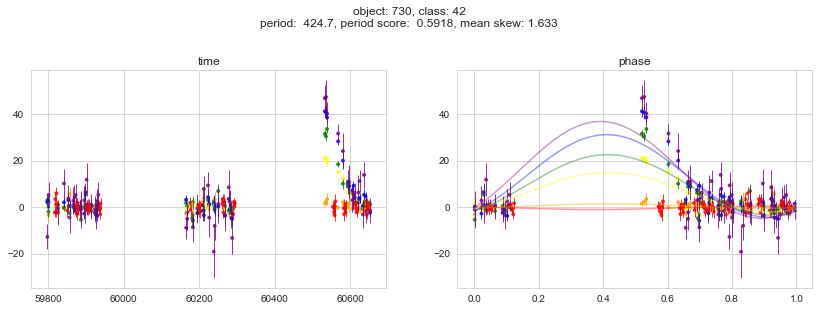

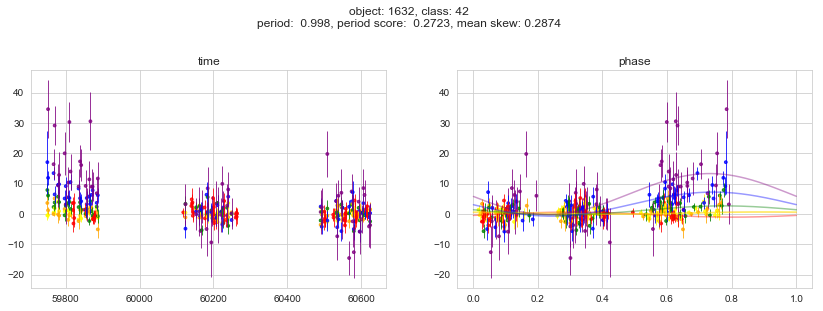

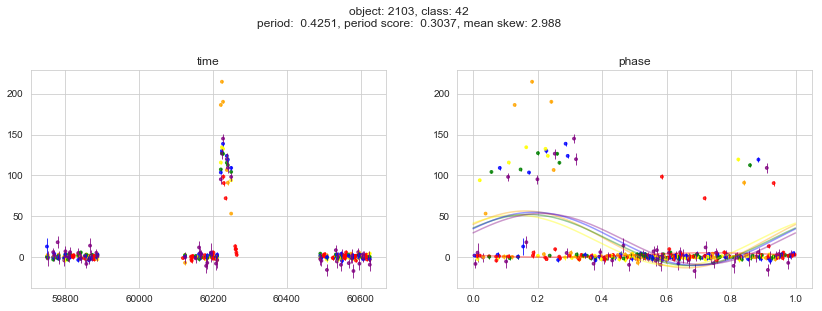

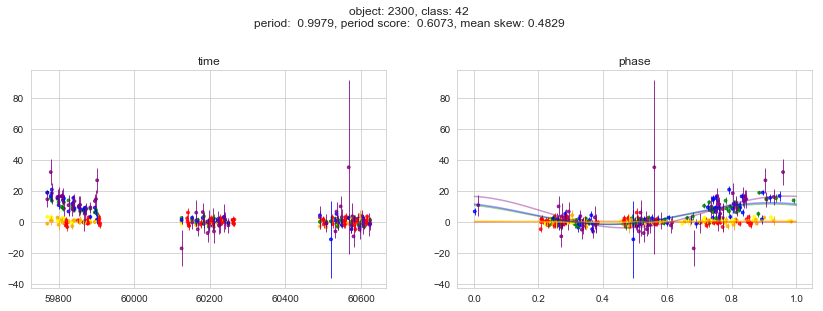

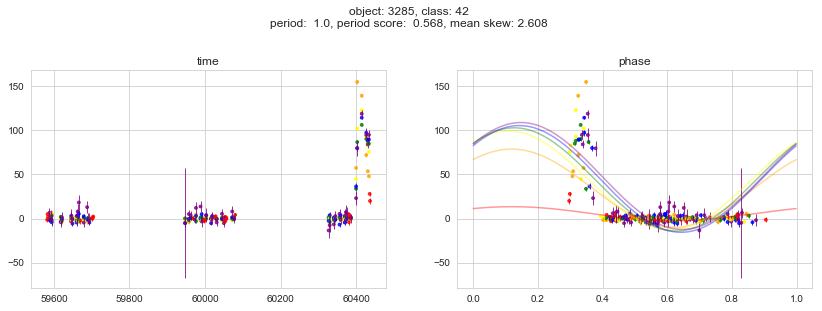

In [29]:
feats, models = get_class_feats(42)
plot_phase_curves(feats, models)

#### Observation:
Class 42 is a very tricky class to classify. It looks very similar to class 90 (type 1a supernova), I am still testing different features to classify this object.

### Class 16

Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 4.2e+02
 - Computing periods at 42432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42724 steps
Zooming-in on 5 candidate

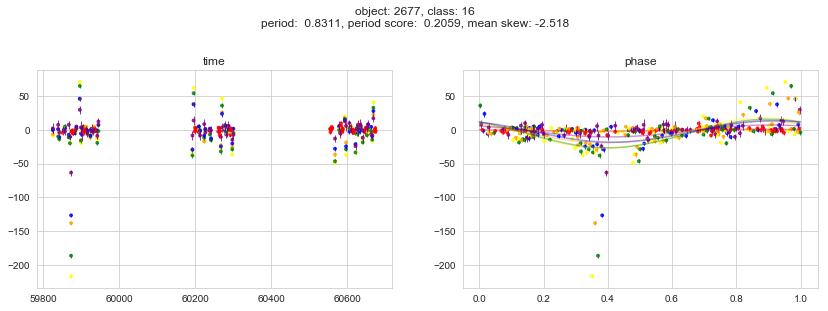

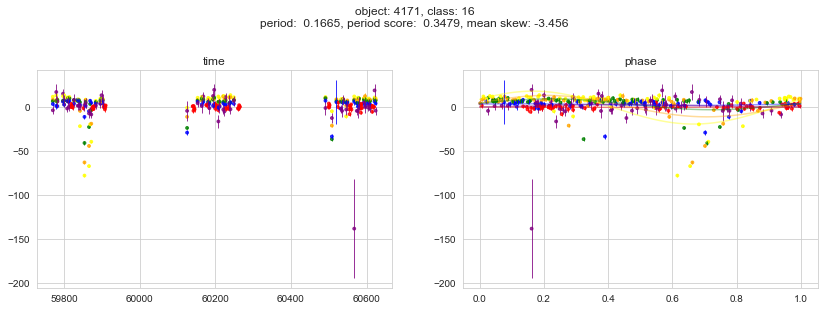

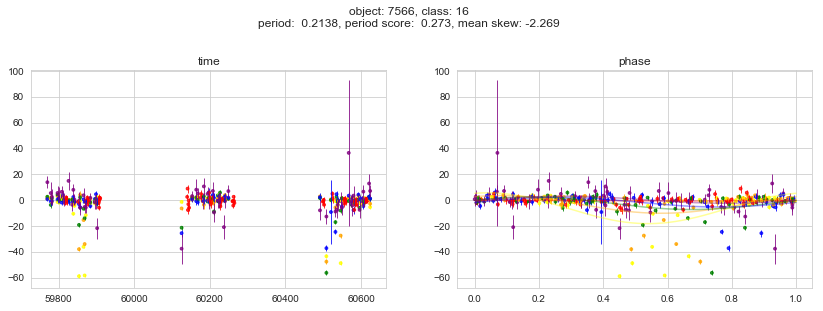

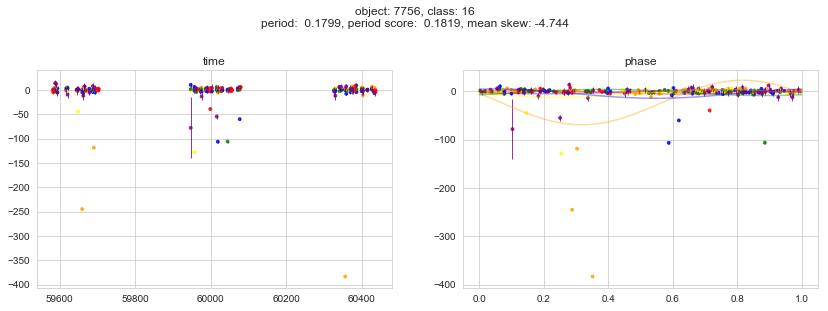

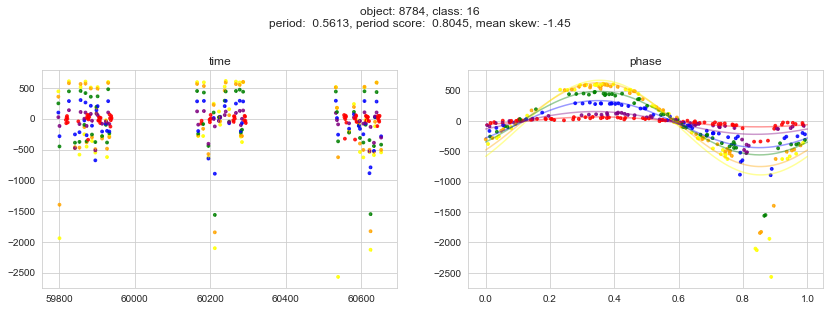

In [31]:
feats, models = get_class_feats(16)
plot_phase_curves(feats, models)

#### Observation:
Class 16 is most likely a binary star(or exoplanet transit) because of its periodic dips in light curves.

## 4. Features Extraction

In [34]:
agg_train = pd.read_csv('agg_train.csv')
print(agg_train.columns)
print(len(agg_train.columns))

Index(['object_id', 'flux_min', 'flux_max', 'flux_mean', 'flux_median',
       'flux_std', 'flux_skew', 'flux_err_min', 'flux_err_max',
       'flux_err_mean', 'flux_err_median', 'flux_err_std', 'flux_err_skew',
       'detected_mean', 'flux_ratio_sq_sum', 'flux_ratio_sq_skew',
       'flux_by_flux_ratio_sq_sum', 'flux_by_flux_ratio_sq_skew', 'flux_diff',
       'flux_dif2', 'flux_w_mean', 'flux_dif3',
       '0__fft_coefficient__coeff_0__attr_"abs"',
       '0__fft_coefficient__coeff_1__attr_"abs"', '0__kurtosis', '0__skewness',
       '1__fft_coefficient__coeff_0__attr_"abs"',
       '1__fft_coefficient__coeff_1__attr_"abs"', '1__kurtosis', '1__skewness',
       '2__fft_coefficient__coeff_0__attr_"abs"',
       '2__fft_coefficient__coeff_1__attr_"abs"', '2__kurtosis', '2__skewness',
       '3__fft_coefficient__coeff_0__attr_"abs"',
       '3__fft_coefficient__coeff_1__attr_"abs"', '3__kurtosis', '3__skewness',
       '4__fft_coefficient__coeff_0__attr_"abs"',
       '4__fft_coefficie

Currently I have included 66 features in the model. This is still a work in progress and I plan to add some more features revolving around the peak and its decay rate (before cleaning some features etc.). The detailed feature extraction function is included in the "features.py". 

## 5. Model

For classification, I am using LightGBM library. This is a light weighted decision tree based framework. Easy to set up and test things on the fly. Very cool.

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.806745	training's wloss: 0.798426	valid_1's multi_logloss: 1.15592	valid_1's wloss: 0.961203
[200]	training's multi_logloss: 0.532108	training's wloss: 0.519742	valid_1's multi_logloss: 0.918517	valid_1's wloss: 0.761376
[300]	training's multi_logloss: 0.407434	training's wloss: 0.394513	valid_1's multi_logloss: 0.819473	valid_1's wloss: 0.699003
[400]	training's multi_logloss: 0.336667	training's wloss: 0.32339	valid_1's multi_logloss: 0.769444	valid_1's wloss: 0.676036
[500]	training's multi_logloss: 0.286589	training's wloss: 0.27364	valid_1's multi_logloss: 0.733702	valid_1's wloss: 0.661636
Early stopping, best iteration is:
[500]	training's multi_logloss: 0.286589	training's wloss: 0.27364	valid_1's multi_logloss: 0.733702	valid_1's wloss: 0.661636
0.661636044777091
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.80667	training's wloss: 0

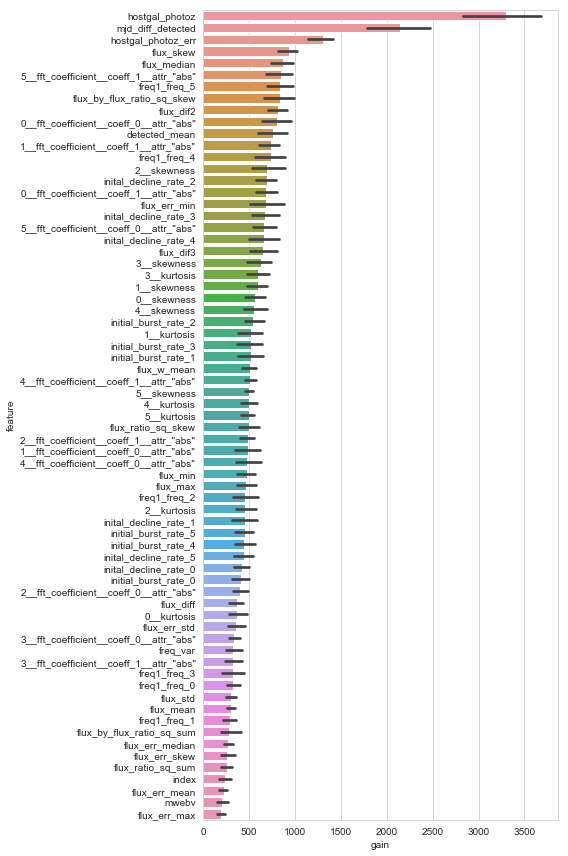

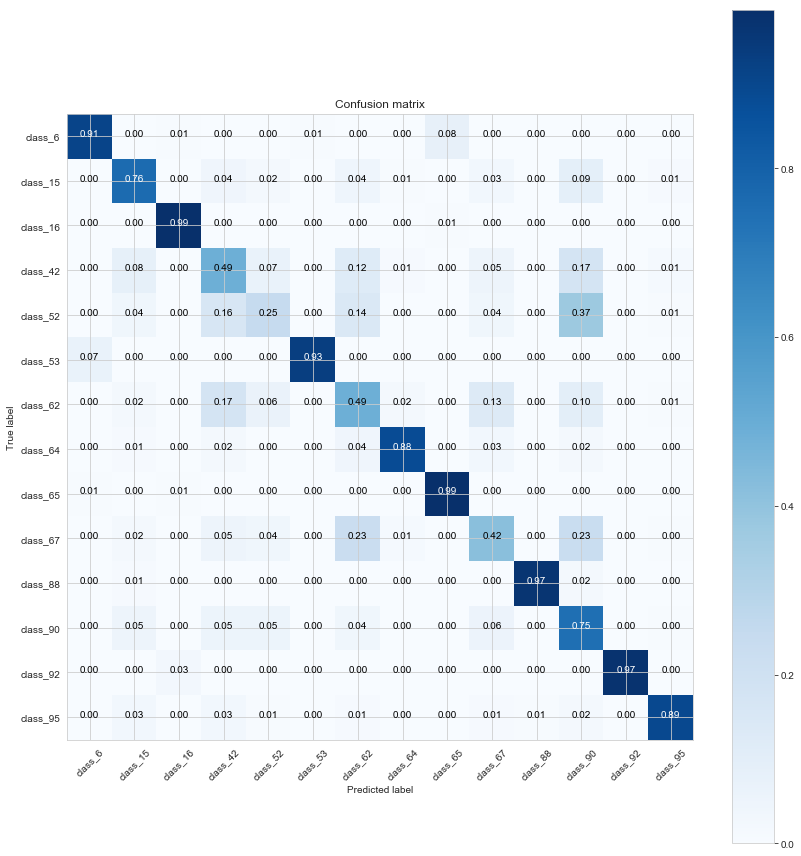

In [38]:
from features import *
train = pd.read_csv('training_set.csv')
agg_train = pd.read_csv('agg_train.csv')
meta_train = pd.read_csv('training_set_metadata.csv')
full_train = agg_train.reset_index().merge(right=meta_train,how='outer',on='object_id')

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']


classes = sorted(y.unique())
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

oof_df = full_train['object_id']

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']

train_mean = full_train.mean(axis=0)
full_train.fillna(0, inplace=True)

w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .9,
    'colsample_bytree': 0.5,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'silent': -1,
    'verbose': -1,
    'max_depth': 3
}

w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full_train.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))


save_importances(importances_=importances)
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Tricky classes like 42, 52, 62, 67 and 90 are supernova-like burst events. Other classes that exhibit periodic behaviors are actually pretty easy to classify based on their redshift, (combined with median flux redshift actually tells you a lot about the object itself), the skewness of their fluxes and their frequencies.

## 6. Going Forward...

In this section, I will discuss some other things regarding the test data prediction.

Features: As brifely mentioned multiple times, I plan to add some more features around the peak of light curves before cleaning and cutting down features. Although the missing data (peak events out of observation windows) could be a challange.

Class 99: In the test data prediction, which I did not include, there are 15 classes to predict (14 + 1). The class 99 is not included the data set, rather it represents objects scientists have not seen before. Since this is a supervised learning problem, to directly classify objects that we have not seen is impossible. The exact method needs to be tested on the test data...

Test data: The test data is much larger than training data (3 mil objects, around 400x larger). This is set up in a way that it takes time to collect training data since we need to use spectroscopy to confirm the objects. This also means it takes a lot of time to generate features on test data and upload the prediction on test data to see the model performance.

Model optimization: This will ironically happen on test data since the training data is so much smaller compared to test data and it is very easy to overfit ~7800 objects with 14 classes. 